# Explain iris data with lime

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
import re  # Import regex for parsing feature names

# Load dataset
df = pd.read_csv('iris.csv')

# Split the data into features (X) and target variable (y)
X = df.drop(columns=['Id', 'Species'])  # Drop 'Id' and 'Species' columns for features
y = df['Species']  # Target variable

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Decision Tree model
dt_model = DecisionTreeClassifier(random_state=29)
dt_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_dt = dt_model.predict(X_test)

# Select a few instances from the test set
selected_instances = X_test.iloc[:5]  # Selecting the first instance from the test set
selected_labels = y_test.iloc[:5]     # Select the corresponding original label

# Initialize the LIME explainer
explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=np.unique(y_train),
    mode='classification'
)

# Define a function that wraps the model's predict_proba to ensure the input has the correct feature names
def predict_proba_with_names(data):
    data_df = pd.DataFrame(data, columns=X_train.columns)
    return dt_model.predict_proba(data_df)

# Function to extract the feature name based on the logic
def extract_feature_name(feature_string):
    # Find all occurrences of inequality signs (>, <, >=, <=)
    inequalities = re.findall(r'[<>]=?', feature_string)
    
    # If more than one inequality sign exists, take the middle value
    if len(inequalities) > 1:
        # Split by space and return the middle value
        parts = feature_string.split(' ')
        return parts[len(parts)//2]
    else:
        # If only one inequality, take the first value (actual feature name)
        return feature_string.split(' ')[0]

# Explain predictions for the selected instances
for i, instance in enumerate(selected_instances.values):
    # Convert the instance to a DataFrame for easy visualization
    instance_df = pd.DataFrame([instance], columns=X_train.columns)
    
    print(f"Selected instance {i + 1}:")
    print(instance_df.to_string(index=False))  # Display the instance with column names
    print(f"Original label: {selected_labels.iloc[i]}")  # Display the original label (true class)
    print("-" * 50)
    
    # Get the predicted probabilities from the model for this instance (ensure the input has feature names)
    instance_with_names = pd.DataFrame([instance], columns=X_train.columns)  # Ensure correct feature names
    probabilities = dt_model.predict_proba(instance_with_names)[0]  # Extract probabilities for this instance
    class_names = dt_model.classes_  # Get the class labels
    
    print(f"Model's predicted probabilities for instance {i + 1}:")
    for class_name, prob in zip(class_names, probabilities):
        print(f"Class '{class_name}': {prob:.4f}")
    print("-" * 50)
    
    # Generate the explanation using LIME
    exp = explainer.explain_instance(
        data_row=instance,
        predict_fn=predict_proba_with_names,  # Use the wrapped predict_proba function
        num_features=4  # Number of features to display in the explanation
    )
    
    # Print the explanation
    print(f"Explanation for instance {i + 1}:")
    explanation_list = exp.as_list()  # Get the explanation as a list of (feature, importance)
    print(explanation_list)  # Print the explanation
    
    # Add verbal explanation including feature values
    print("\nVerbal explanation:")
    print(f"The original label for this instance is '{selected_labels.iloc[i]}'.")
    print(f"The model predicts this instance to belong to class '{class_names[np.argmax(probabilities)]}' with a probability of {max(probabilities):.4f}.")
    
    # Loop through the explanation list and match with actual feature names
    for feature, importance in explanation_list:
        # Extract the feature name based on the provided logic
        feature_name = extract_feature_name(feature)
        
        # Get the actual value of the feature from the instance DataFrame
        if feature_name in X_train.columns:
            feature_value = instance_df[feature_name].values[0]
            
            # Verbal explanation based on the feature importance
            if importance > 0:
                print(f"The feature '{feature_name}' with a value of {feature_value} contributes positively to this prediction, with an importance score of {importance:.4f}.")
            else:
                print(f"The feature '{feature_name}' with a value of {feature_value} contributes negatively to this prediction, with an importance score of {importance:.4f}.")
        else:
            print(f"Feature '{feature}' could not be matched directly.")
    
    print("-" * 50)
    print("-" * 50)
    print("-" * 50)
    
    # Save the explanation to an HTML file
    exp.save_to_file(f"lime_explanation_instance_{i + 1}.html")


Selected instance 1:
 SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
           6.1           2.8            4.7           1.2
Original label: Iris-versicolor
--------------------------------------------------
Model's predicted probabilities for instance 1:
Class 'Iris-setosa': 0.0000
Class 'Iris-versicolor': 1.0000
Class 'Iris-virginica': 0.0000
--------------------------------------------------
Explanation for instance 1:
[('0.30 < PetalWidthCm <= 1.30', 0.30452629227811173), ('4.25 < PetalLengthCm <= 5.10', 0.09775331306287928), ('5.75 < SepalLengthCm <= 6.40', 0.020022231488249824), ('SepalWidthCm <= 2.80', -0.004176667205363418)]

Verbal explanation:
The original label for this instance is 'Iris-versicolor'.
The model predicts this instance to belong to class 'Iris-versicolor' with a probability of 1.0000.
The feature 'PetalWidthCm' with a value of 1.2 contributes positively to this prediction, with an importance score of 0.3045.
The feature 'PetalLengthCm' with a value 

('0.30 < PetalWidthCm <= 1.30' means feature should lie in that range. 0.2886 is value for it.
saved html files have visual explanations.
Explanations are consistent with model output

# Explain housing data with shap

started force plot
finished force plot


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


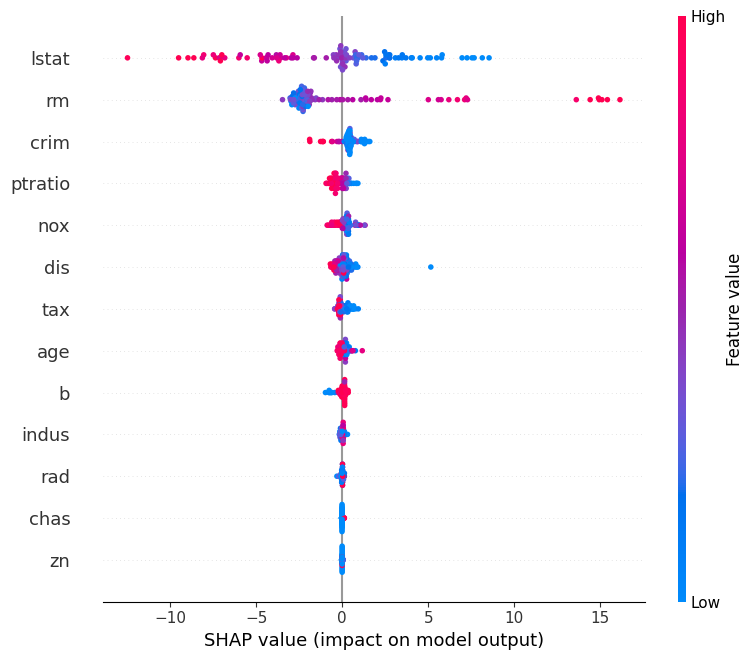

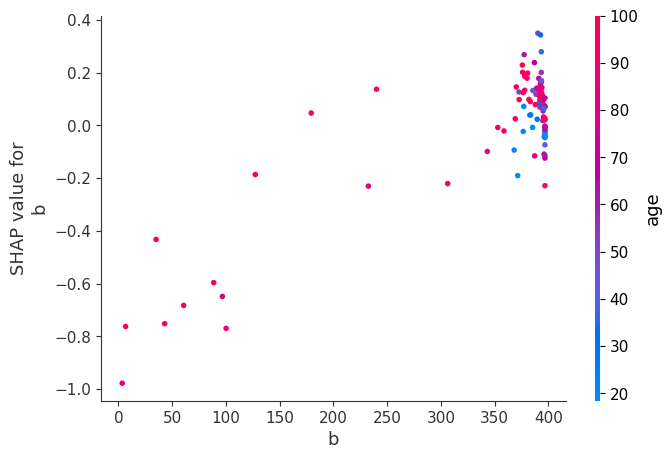

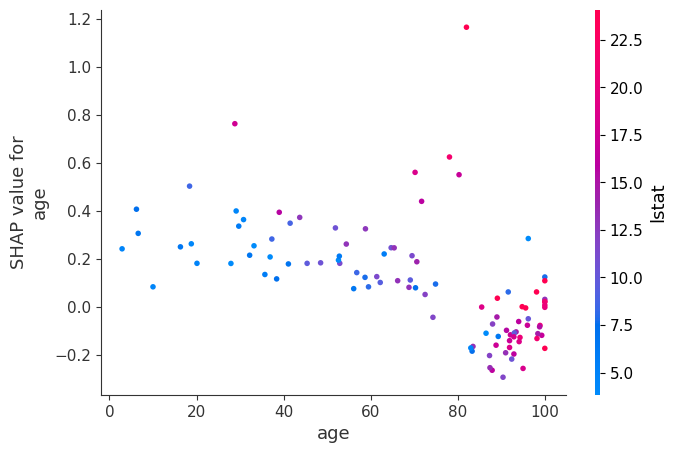

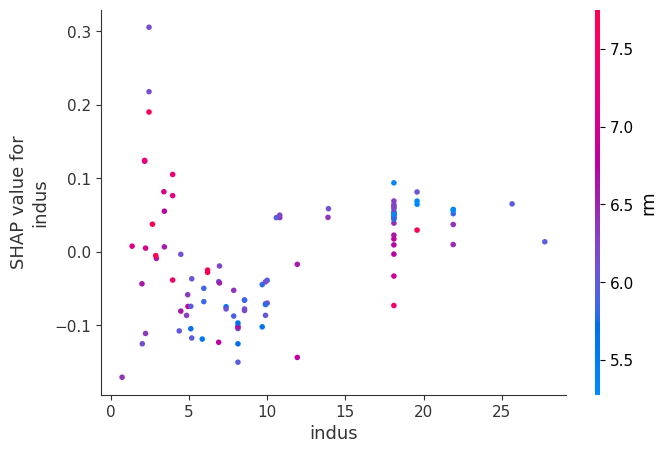

In [8]:
import shap
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

data = pd.read_csv('BostonHousing.csv')

# Separate the features (X) and target (y)
X = data.drop(columns=['medv'])  # 'medv' is the target variable (median value of owner-occupied homes)
y = data['medv'] 

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=29)

# Step 4: Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 5: Use SHAP to explain the model's predictions
# Initialize the SHAP explainer
explainer = shap.TreeExplainer(model)

# Choose multiple instances from the test set to explain
instances_to_explain = X_test.iloc[:5]

# Generate SHAP values for these instances
shap_values = explainer.shap_values(instances_to_explain)

# Step 6: Visualize the SHAP values
# Plot the SHAP values for the selected instances
shap.initjs()  # For rendering visuals in notebooks
print("started force plot")
shap.force_plot(explainer.expected_value, shap_values, instances_to_explain)
print("finished force plot")


# Step 7: SHAP Summary Plot
# This plot summarizes the importance of features across the entire dataset
shap_values_all = explainer.shap_values(X_test)  # SHAP values for all instances in the test set
shap.summary_plot(shap_values_all, X_test)

# Step 8: SHAP Dependence Plot
# Select a feature (e.g., 'MedInc') and visualize its effect on predictions
shap.dependence_plot('b', shap_values_all, X_test)
shap.dependence_plot('age', shap_values_all, X_test)
shap.dependence_plot('indus', shap_values_all, X_test)


# Explain mnist data with lime 

In [ ]:

from sklearn.metrics import accuracy_score

from skimage.segmentation import mark_boundaries

import torchaudio
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as vtransforms

from torch.utils.data import DataLoader

from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms

# Set the GPU if available otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'PyTorch version= {torch.__version__}')
print(f'torchaudio version= {torchaudio.__version__}')
print(f'torchvision version= {torchvision.__version__}')
print(f'CUDA available= {torch.cuda.is_available()}')

if torch.cuda.is_available():
    # CUDA Installation
    print('CUDA Version')
    !nvcc --version
    print()

    # CUDNN Installation
    print(f'CUDNN Version: {torch.backends.cudnn.version()}')
    print(f'Number of CUDA Devices: {torch.cuda.device_count()}')
    print(f'Active CUDA Device: {torch.cuda.current_device()}')
    print(f'Available devices: {torch.cuda.device_count()}, Name: {torch.cuda.get_device_name(0)}')
    print(f'Current CUDA device: {torch.cuda.current_device()}')

In [ ]:
# Get the training and testing datasets from a path with resize and normalization
def get_dataloader(_img_size, _bs, _ds, _path):
    train_ds = _ds(
        root=_path, download=True, train=True,
        transform=vtransforms.Compose([
            vtransforms.Resize(_img_size),
            vtransforms.ToTensor(),
            vtransforms.Normalize((0.5,), (0.5,))
        ]))

    # Use pin_memory=True to fix GPU memory
    train_dl = torch.utils.data.DataLoader(train_ds, batch_size=_bs, shuffle=True,
                                           # pin_memory=True,
                                           num_workers=4)

    test_ds = _ds(
        root=_path, download=True, train=False,
        transform=vtransforms.Compose([
            vtransforms.Resize(_img_size),
            vtransforms.ToTensor(),
            vtransforms.Normalize((0.5,), (0.5,))
        ]))

    test_dl = torch.utils.data.DataLoader(test_ds, batch_size=_bs, shuffle=True,
                                          # pin_memory=True,
                                          num_workers=4)

    return train_dl, test_dl

def get_dl_mnist(_img_size, _bs):
    return get_dataloader(_img_size, _bs, dset.MNIST, './MNIST')

In [ ]:
IMG_SIZE = 28
IMG_CHANNEL= 1  # color channel
MLP_HIDDEN= 16  # Hidden layer size
LAST_LINEAR_SIZE = 1024
N_CLASSES = 10  # output layer size
BATCH_SIZE = 5000

class ImageClassifierCNN(torch.nn.Module):
    def __init__(
            self, 
            epochs=10, 
            eta=0.001, 
            batch_size=1000, 
            seed=0
        ) -> None:
        super(ImageClassifierCNN, self).__init__()
        self.random = np.random.RandomState(seed)  # shuffle mini batches
        self.epochs = epochs  # number of iterations
        self.eta = eta  # learning rate
        self.batch_size = batch_size 
        self.loss_func = torch.nn.CrossEntropyLoss()
        self.model = None

    def init_layers(self, _K):
        import torch.nn as nn
        self.model = nn.Sequential(
            nn.Conv2d(IMG_CHANNEL, MLP_HIDDEN, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(MLP_HIDDEN),
            nn.Conv2d(MLP_HIDDEN, MLP_HIDDEN*2, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Flatten(start_dim=1),
            nn.Linear(MLP_HIDDEN*2 * 4*4, LAST_LINEAR_SIZE),
            nn.BatchNorm1d(LAST_LINEAR_SIZE),
            nn.Linear(LAST_LINEAR_SIZE, _K),
        ).to(device)

    def predict(self, input):
        if input.shape[-1] == 3:
            input = np.mean(input, axis=-1, keepdims=True)
        
        input = np.transpose(input, (0, 3, 1, 2))
        
        input = torch.FloatTensor(input).to(device, non_blocking=True)
        assert self.model is not None
        with torch.no_grad():
            logits = self.model(input)
        probabilities = F.softmax(logits, dim=1)
        return probabilities.cpu().numpy()

    def fit(self, _train_dl, info=False):
        import sys
        self.init_layers(N_CLASSES)

        optimizer = torch.optim.Rprop(self.model.parameters(), lr=self.eta)

        for e in range(self.epochs):
            for data in _train_dl:
                X, y = data[0].to(device), data[1].to(device)

                optimizer.zero_grad()
                net_out = self.model(X)
                loss = self.loss_func(net_out, y)
                loss.backward()
                optimizer.step()
                
            if info:
                with torch.no_grad():
                    acc = accuracy_score(data[1].tolist(), np.argmax(self.model(X).cpu(), axis=1).tolist())
                sys.stderr.write(f"\r{e+1:02d}/{self.epochs:02d} | Loss: {loss:<6.2f} | Tr Acc: {acc*100:3.2f}%")
                sys.stderr.flush()

In [ ]:
cnn = ImageClassifierCNN(batch_size=BATCH_SIZE).to(device)
cnn.init_layers(N_CLASSES)
print(cnn)

In [ ]:
%%time

# Get the datasets
train_dl, test_dl = get_dl_mnist(IMG_SIZE, BATCH_SIZE)

cnn.fit(train_dl, info=True) 

In [ ]:
# Ensure the model is in evaluation mode
cnn.eval()

# Initialize LimeImageExplainer
explainer = lime_image.LimeImageExplainer()

# Function to preprocess input image for the model
def preprocess(image):
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,))])
    return transform(image).unsqueeze(0)

In [ ]:
# Initialize a dictionary to store one image for each digit
digit_examples = {}

# Iterate over the test data loader to collect one example for each digit
for images, labels in test_dl:
    labels_list = labels.tolist()
    for i, label in enumerate(labels_list):
        if label not in digit_examples:
            # Detach the image tensor and convert to numpy array
            digit_examples[label] = images[i].detach().numpy()
            
        # If we've collected all digits, break out of loop
        if len(digit_examples) == 10:
            break
            
    # If we've collected all digits, break out of loop
    if len(digit_examples) == 10:
        break

# Create a SegmentationAlgorithm object with 'slic' algorithm
segmentation_fn = SegmentationAlgorithm('slic', n_segments=100, compactness=1, sigma=1)

# Now iterate through each digit and explain using LIME
for digit in range(10):
    # Retrieve the selected image of the digit from the dictionary
    image = np.squeeze(digit_examples[digit])

    # Get explanation from LIME
    explanation = explainer.explain_instance(image, 
                                             cnn.predict, 
                                             top_labels=5, 
                                             hide_color=0, 
                                             num_samples=1000,
                                             segmentation_fn=segmentation_fn)
  
    # Get image and mask for the explanation of the digit
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                                positive_only=True, 
                                                num_features=5, 
                                                hide_rest=False)
    
    # Plot the image and the explanation
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Original Image: {digit}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mark_boundaries(temp, mask))
    plt.title(f'LIME Explanation for {digit}')
    plt.axis('off')

    plt.show()

# Explain mnsit with shap

In [ ]:
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms

import shap

batch_size = 128
num_epochs = 2
device = torch.device("cpu")


class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}"
                f" ({100.0 * batch_idx / len(train_loader):.0f}%)]"
                f"\tLoss: {loss.item():.6f}"
            )


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item()  # sum up batch loss
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(
        f"\nTest set: Average loss: {test_loss:.4f},"
        f" Accuracy: {correct}/{len(test_loader.dataset)}"
        f" ({100.0 * correct / len(test_loader.dataset):.0f}%)\n"
    )


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "mnist_data",
        train=True,
        download=True,
        transform=transforms.Compose([transforms.ToTensor()]),
    ),
    batch_size=batch_size,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST("mnist_data", train=False, transform=transforms.Compose([transforms.ToTensor()])),
    batch_size=batch_size,
    shuffle=True,
)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

In [ ]:
# since shuffle=True, this is a random sample of test data
batch = next(iter(test_loader))
images, _ = batch

background = images[:100]
test_images = images[100:103]

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)


shap_numpy = list(np.transpose(shap_values, (4, 0, 2, 3, 1)))
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

# plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy)

# Explain imageNet with Inception by Lime

In [ ]:

import torch
from PIL import Image
from torchvision import transforms
import os
import urllib
import matplotlib.pyplot as plt
import time

model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model.eval()  # Set the model to evaluation mode as we are only performing inference


preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


filename1 = 'imagenet_classes.txt'

# Check if the class label file exists locally, if not download it
if not os.path.exists(filename1):
    filename1 = urllib.request.urlretrieve(
        'https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt',
        filename1
    )[0]

# Read and store the class labels
with open(filename1, "r") as f:
    categories = [s.strip() for s in f.readlines()]



image_folder = './ImageNetPics'  # Replace with your folder path

image_paths = [os.path.join(image_folder, fname)
               for fname in os.listdir(image_folder)
               if fname.endswith(('.jpg', '.jpeg', '.png', '.JPEG'))]


from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np


def predict_image_with_lime(image_path):
    # Load and preprocess the image
    input_image = Image.open(image_path).convert('RGB')  # Ensure the image is in RGB mode

    # Preprocess the image
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

    # Move the input and model to GPU for speed if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    input_batch = input_batch.to(device)
    model.to(device)

    # Get the model's predictions
    with torch.no_grad():
        output = model(input_batch)

    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    top5_prob, top5_catid = torch.topk(probabilities, 5)

    print("Top 5 predictions:")
    for i in range(top5_prob.size(0)):
        print(f"{categories[top5_catid[i]]}: {top5_prob[i].item():.4f}")

    # Convert the input image to a NumPy array (for LIME)
    input_image_np = np.array(input_image)

    # Create a LIME explainer
    explainer = lime_image.LimeImageExplainer()

    # Define a prediction function that operates on the GPU
    def predict_fn(images):
        batch = torch.stack([preprocess(Image.fromarray(image)) for image in images])
        batch = batch.to(device)
        with torch.no_grad():
            outputs = model(batch)
        probabilities = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
        return probabilities

    # Get LIME explanation for the top class
    explanation = explainer.explain_instance(input_image_np, predict_fn, top_labels=5, hide_color=0, num_samples=1000)

    # Get the explanation for the top class
    temp, mask = explanation.get_image_and_mask(top5_catid[0].item(), positive_only=True, num_features=5, hide_rest=False)

    # Display the image with LIME explanation
    plt.imshow(mark_boundaries(temp, mask))
    plt.axis('off')  # Hide the axis for better visualization
    plt.show()


for image_path in image_paths:
    print(f"Predicting for image: {image_path}")

    try:
        predict_image_with_lime(image_path)
    except Exception as e:
        print(f"An error occurred with image {image_path}: {e}")

    print()  # Add space between predictions for clarity
